## Topic Modeling
This module primarily focuses on data preprocessing for topic modeling, the use of LDA (Latent Dirichlet Allocation) for topic modeling, and the visualization and interpretation of the data processing results.

In [1]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns

# For Topic Modeling and data processing
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
nltk.download('stopwords')
nltk.download('punkt')

from gensim import corpora, models
from gensim.models import CoherenceModel
from gensim.models.phrases import Phrases, Phraser

# Visualization for topic modeling
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

from textblob import TextBlob
from docx import Document


[nltk_data] Downloading package stopwords to /Users/lorna/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/lorna/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
# Load the spaCy English model
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Define a set of custom stop words and update spaCy's stop words collection（adjust based on multiple experiments)
custom_stop_words = ["s","t","ms","g","b","dr","ve","m","mr","nyt","cnn","fox"]
for word in custom_stop_words:
    nlp.vocab[word].is_stop = True

def preprocess_text(text):
    # Use Regular Expressions to remove numbers and non-alphabetic characters
    text = re.sub(r'[^a-zA-Z\s]', '', text.lower())
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc if token.is_alpha and not token.is_stop]
    processed_text = ' '.join(tokens)
    return processed_text

# Read the Excel file
df = pd.read_excel('Cleaned_2015_2022Nov.xlsx')

# Apply text processing function
df['Processed_Body'] = df['Body'].apply(preprocess_text)

# Save the processed data to a new Excel file
df.to_excel('TM_2015to2022.xlsx', index=False)


### Topic Modeling with LDA model 


In [2]:
# Load Preprocessed Data
df = pd.read_excel('TM_2015to2022.xlsx')

# Tokenization
texts = df['Processed_Body'].apply(lambda x: word_tokenize(x.lower()))

# Create a dictionary using the tokenized texts
dictionary = corpora.Dictionary(texts)

# Filter out extreme terms: Remove terms that appear in less than 3 documents and also eliminate terms that appear in more than 40% of the documents.
dictionary.filter_extremes(no_below=3, no_above=0.4)

# Generate a corpus (Bag of Words)
corpus = [dictionary.doc2bow(text) for text in texts]

# Build the LDA model
lda_model = models.LdaModel(corpus, 
                            num_topics=10, 
                            id2word=dictionary, 
                            passes=36, 
                            random_state=40,
                            )

# Display the discovered topics
topics = lda_model.print_topics(num_words=10)
for topic in topics:
    print(topic)


(0, '0.010*"president" + 0.007*"video" + 0.007*"trump" + 0.006*"clip" + 0.006*"yes" + 0.005*"thank" + 0.004*"mean" + 0.004*"state" + 0.004*"happen" + 0.004*"talk"')
(1, '0.018*"facebook" + 0.007*"app" + 0.007*"video" + 0.007*"user" + 0.006*"social" + 0.005*"content" + 0.005*"post" + 0.004*"medium" + 0.004*"image" + 0.004*"platform"')
(2, '0.011*"student" + 0.009*"law" + 0.008*"facial" + 0.008*"police" + 0.008*"school" + 0.007*"recognition" + 0.006*"privacy" + 0.006*"algorithm" + 0.005*"camera" + 0.005*"bias"')
(3, '0.021*"china" + 0.013*"chinese" + 0.010*"united" + 0.010*"states" + 0.009*"american" + 0.005*"official" + 0.005*"country" + 0.005*"administration" + 0.005*"billion" + 0.005*"security"')
(4, '0.014*"president" + 0.008*"trump" + 0.006*"border" + 0.006*"biden" + 0.006*"country" + 0.005*"talk" + 0.005*"yes" + 0.005*"house" + 0.004*"lot" + 0.004*"american"')
(5, '0.007*"robot" + 0.006*"life" + 0.004*"musk" + 0.004*"book" + 0.004*"story" + 0.004*"idea" + 0.003*"kind" + 0.003*"age"

#### Check the coherence score

In [6]:
# Calculate the coherence score
coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print(f'Coherence Score: {coherence_lda}')


Coherence Score: 0.5140921569914723


#### Visualization and Interpretation of Topic Modeling

In [35]:
# Use pyLDAvis to visualize the results of LDA topic modeling
vis_data = gensimvis.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(vis_data)


### The distribution of each topic throughout the documents
To understand which topics are more common or important across the entire document collection, appearing as the dominant topic in more documents, the following module first determines the dominant topic of each document, then counts the number of documents for each dominant topic, and finally visualizes the document distribution.

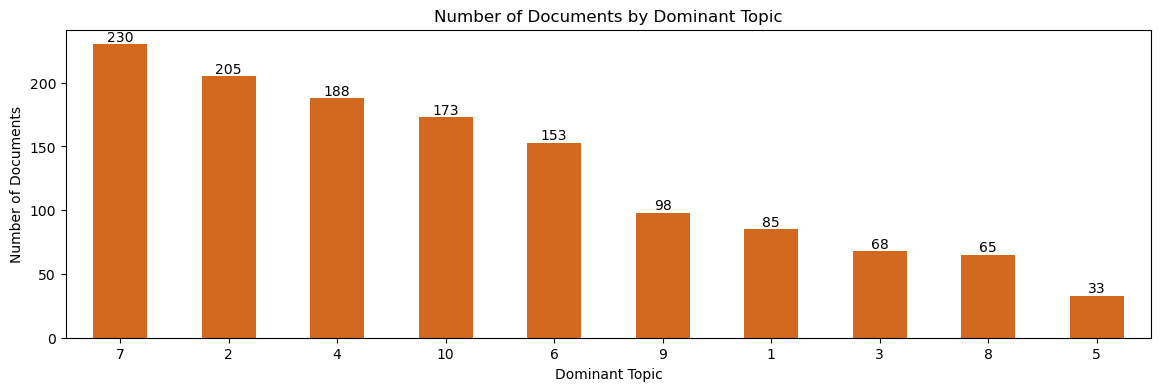

In [3]:
# Determine the dominant topic of each document
dominant_topics = []
for _, row_list in enumerate(lda_model[corpus]):
    dominant_topic = sorted(row_list, key=lambda x: (x[1]), reverse=True)[0][0]
    # Since the topic index starts from 0 by default, add 1 here to make it start from 1.
    dominant_topics.append(dominant_topic + 1)

# Add the dominant topic column to DataFrame
df['Dominant_Topic'] = dominant_topics

# Count the number of documents on dominant topics
dominant_topic_counts = df['Dominant_Topic'].value_counts().sort_index()

# Sort the topics in descending order based on the number of documents
topic_counts_sorted = dominant_topic_counts.sort_values(ascending=False)

# Plot the distribution of documents for each dominant topic
plt.figure(figsize=(14, 4))
ax = topic_counts_sorted.plot(kind='bar', color='chocolate')
plt.title('Number of Documents by Dominant Topic')
plt.xlabel('Dominant Topic')
plt.ylabel('Number of Documents')
plt.xticks(rotation=0)

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')
plt.show()


In [5]:
# Determine the dominant topic for each document
dominant_topics = []
for _, row_list in enumerate(lda_model[corpus]):
    dominant_topic = sorted(row_list, key=lambda x: (x[1]), reverse=True)[0][0]
    # The topic index starts from 0 by default, adding 1 to start from 1
    dominant_topics.append(dominant_topic + 1)

# Add the dominant topic to the DataFrame
df['Dominant_Topic'] = dominant_topics

# Count the number of documents for each dominant topic
dominant_topic_counts = df['Dominant_Topic'].value_counts().sort_index()

# Calculate the percentage of each dominant topic and round to one decimal place
dominant_topic_percentage = df['Dominant_Topic'].value_counts(normalize=True).mul(100).round(1)

# Combine the counts and percentages into a single DataFrame
topic_stats = pd.DataFrame({'Count': dominant_topic_counts, 'Percentage (%)': dominant_topic_percentage})

# Sort the statistics by percentage in descending order
topic_stats_sorted = topic_stats.sort_values(by='Percentage (%)', ascending=False)

# Print the sorted statistical results
print(topic_stats_sorted)



                Count  Percentage (%)
Dominant_Topic                       
7                 230            17.7
2                 205            15.8
4                 188            14.5
10                173            13.3
6                 153            11.8
9                  98             7.6
1                  85             6.5
3                  68             5.2
8                  65             5.0
5                  33             2.5


### # Extract the top 20% of documents based on topic probability scores

In [3]:
# Determine the dominant topic and its probability for each document
dominant_topics = []
topic_probabilities = []
for _, row_list in enumerate(lda_model[corpus]):
    sorted_row_list = sorted(row_list, key=lambda x: (x[1]), reverse=True)
    dominant_topic, dominant_topic_probability = sorted_row_list[0]
    dominant_topics.append(dominant_topic + 1)  # Adjust topic numbering to start from 1 instead of 0
    topic_probabilities.append(dominant_topic_probability)

# Add dominant topic and its probability score to the DataFrame
df['Dominant_Topic'] = dominant_topics
df['Dominant_Topic_Prob'] = topic_probabilities


In [5]:
top_documents = {}
num_topics = 10

# Extract the top 20% of documents for each topic
for topic in range(1, num_topics + 1):
    topic_df = df[df['Dominant_Topic'] == topic]
    if not topic_df.empty:
        # Sort by probability score in descending order and select the top 20%
        top_20_percent = topic_df.nlargest(int(len(topic_df) * 0.2), 'Dominant_Topic_Prob')
        top_documents[topic] = top_20_percent
    else:
        top_documents[topic] = pd.DataFrame()  # Handle empty DataFrame case

# Create a Word document
doc = Document()
doc.add_heading('Top 20% Documents from All Topics', level=1)

# Prepare a list to hold Excel data
excel_data = []

# Initialize a dictionary to count the number of documents extracted for each topic
topic_document_counts = {}

# Iterate through each topic and add document content to the Word and Excel files
for topic, docs in top_documents.items():
    if not docs.empty:
        doc.add_heading(f'Topic {topic}', level=2)
        
        for index, row in docs.iterrows():
            doc.add_heading(f'Document {index}', level=3)
            doc.add_paragraph(row['Body'])  # Ensure 'Body' column exists
            
            # Process the time column to remove the time part
            date_only = pd.to_datetime(row['Time']).date()
            
            # Add to the Excel data list
            excel_data.append({
                'Topic': topic,
                'Date': date_only,  # Date without time part
                'Content': row['Body']
            })
        
        # Record the number of documents extracted for the current topic
        topic_document_counts[topic] = len(docs)

# Save the Word document
doc.save('All_Top_Documents.docx')

# Convert all data to a DataFrame and save it as an Excel file
excel_df = pd.DataFrame(excel_data)
excel_df.to_excel('All_Top_Documents.xlsx', index=False)

# Output the number of documents extracted for each topic
for topic, count in topic_document_counts.items():
    print(f"Topic {topic} has {count} documents extracted.")

print("Word and Excel documents have been created with all topics combined.")


Topic 1 has 17 documents extracted.
Topic 2 has 41 documents extracted.
Topic 3 has 13 documents extracted.
Topic 4 has 37 documents extracted.
Topic 5 has 6 documents extracted.
Topic 6 has 30 documents extracted.
Topic 7 has 46 documents extracted.
Topic 8 has 13 documents extracted.
Topic 9 has 19 documents extracted.
Topic 10 has 34 documents extracted.
Word and Excel documents have been created with all topics combined.


In [ ]:
# Initialize a list to store data for the final table
table_data = []

# Prepare a list to hold Excel data
excel_data = []

# Iterate through each topic and collect document content
for topic, docs in top_documents.items():
    if not docs.empty:
        for index, row in docs.iterrows():
            # Process the time column to remove the time part
            date_only = pd.to_datetime(row['Time']).date()

            # Append data to the list for the final table
            table_data.append({
                'Topic': topic,
                'Document_Index': index,
                'Date': date_only,  # Date without time part
                'Content': row['Body'],
                'Probability': row['Dominant_Topic_Prob']
            })

        # Also add the count of documents for this topic
        table_data.append({
            'Topic': f'Topic {topic} - Total Count',
            'Document_Index': '',
            'Date': '',
            'Content': '',
            'Probability': len(docs)
        })

# Convert the list to a DataFrame
final_table_df = pd.DataFrame(table_data)

# Save the final table as an Excel file
final_table_df.to_excel('2015_Top_20_Percent_Documents.xlsx', index=False)

print("The table with the top 20% documents for each topic, including counts, has been saved to 'Top_20_Percent_Documents_With_Counts.xlsx'.")
